In [1]:
import numpy as np
import pandas as pd
import warnings
import shap
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/ziqili/Desktop/geoshapley-main/geoshapley')

In [3]:
from geoshapley import GeoShapleyExplainer

## Data Generating Processes

In [4]:
size=50
n = size*size

b0 = np.ones(size*size).reshape(size,size)
b1 = np.ones(size*size).reshape(size,size)
b2 = np.ones(size*size).reshape(size,size)

for i in range(size):
    for j in range(size):
        b0[i][j] = 6/(12.5**4)*(12.5**2-(12.5-i/2)**2)*(12.5**2-(12.5-j/2)**2)
        b1[i,j] = (i+j)/49*3

b2 = np.flip(b1,axis=1).T

b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = np.ones(size*size).reshape(-1)*2

In [5]:
def plot_s(b,sub_title=['','','','',''],title="",non_spatial=[],vmin=None,vmax=None,interpolation=None):
    k = len(b)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=600)
    for i in range(k):
        for m in non_spatial:
            if i == m[0]: 
                ax = axs[i].scatter(m[1],m[2],s=5,color="black")
                axs[i].set_ylim([m[3],m[4]])
                axs[i].set_xlim([-2.5,2.5])
                #axs[i].set_ylabel(r'$\phi_{}$'.format(i),fontsize=16)
                axs[i].set_xlabel(r'$X_{}$'.format(i),fontsize=16)
                
                break
                
        else:
            ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax,interpolation=interpolation)
        
            fig.colorbar(ax, ax=axs[i])

            axs[i].set_xticks(np.arange(-0.5, size, 5))
            axs[i].set_yticks(np.arange(-0.5, size, 5))
            axs[i].set_xticklabels([])
            axs[i].set_yticklabels([])
        
            axs[i].tick_params(axis='x', colors=(0,0,0,0))
            axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
        axs[i].set_title(sub_title[i],fontsize=20,y=1.05)
    
    #fig.suptitle(title, fontsize=25,y=1.1)
    
    #plt.savefig(title + ".png",bbox_inches='tight')

In [6]:
np.random.seed(222)

X1 = np.random.uniform(-2,2,size*size)
X2 = np.random.uniform(-2,2,size*size)
X3 = np.random.uniform(-2,2,size*size)
X4 = np.random.uniform(-2,2,size*size)

err = np.random.randn(size*size)

X = np.vstack([X1,X2,X3,X4]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1];n = X.shape[0]

In [7]:
names=['X1','X2','X3','X4','x_coord','y_coord']

X_coords = pd.DataFrame(np.concatenate([X,np.array(coords)],axis=1),columns=names)

X_coords = X_coords - X_coords.mean(axis=0)

In [8]:
f0 = b0
f1 = b1*X_coords.values[:,0]
f2 = b2*X_coords.values[:,1]
f3 = b3*X_coords.values[:,2]
f4 = X_coords.values[:,3]**2

y = pd.DataFrame(f0 + f1 + f2 + f3 + f4,columns=['y'])


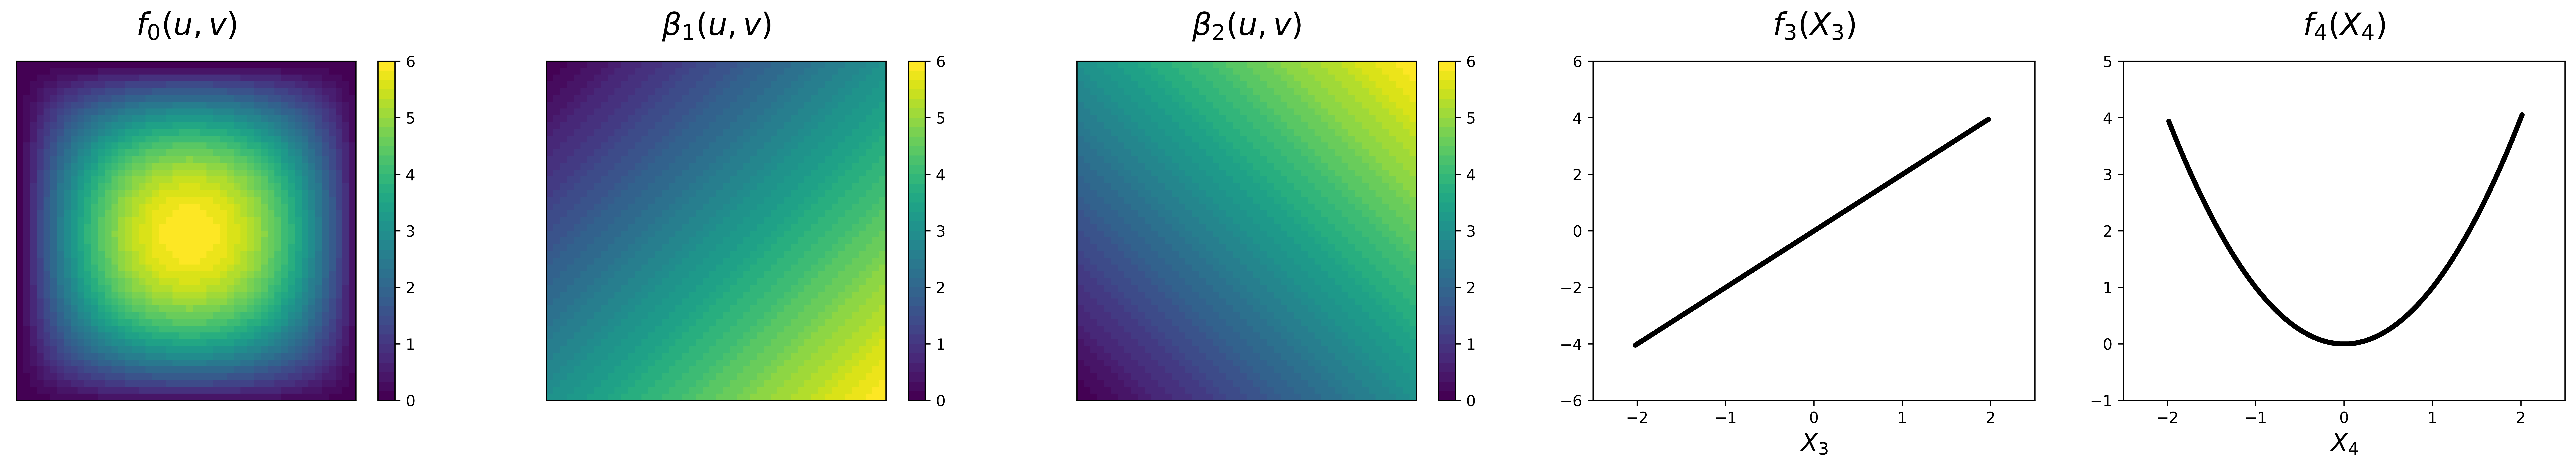

In [9]:
warnings.filterwarnings('ignore')
sub_t = [r"$f_0(u,v)$",r"$\beta_1(u,v)$",r"$\beta_2(u,v)$",r"$f_{3}(X_{3})$", r"$f_{4}(X_{4})$"]
plot_s(np.vstack([b0,b1,b2,b3,b2]),sub_title=sub_t,vmin=0,vmax=6,title="Data Generating Processes",
       non_spatial=[[3,X_coords.values[:,2], f3,-6,6],
                    [4,X_coords.values[:,3], f4,-1,5]])

## Define a true model

In [10]:
class TrueModel:
  def __init__(self,f):
    self.predict = f

def predict(X_coords):
    
    try:
        X_coords = X_coords.values
    except:
        pass
    
    n,k = X_coords.shape
    
    predy = []
    
    for i in range(n): 
        
        u = X_coords[i,-1] + 24.5
        v = X_coords[i,-2] + 24.5
        
        f0 = 6/(12.5**4)*(12.5**2-(12.5-u/2)**2)*(12.5**2-(12.5-v/2)**2)
        f1 = ((u+v)/49*3)*X_coords[i,0]
        f2 = ((49-u+v)/49*3)*X_coords[i,1]
        f3 = 2*X_coords[i,2]
        f4 = X_coords[i,3]**2
        
        predy_i = f0 + f1 + f2 + f3 + f4
        
        predy.append(predy_i)

    return np.array(predy)

In [11]:
true_model = TrueModel(predict)

## Explain the true model

Define a Background data

In [12]:
background_X = X_coords.sample(100).values
background_X[:,:-2] = 0

In [13]:
explainer = GeoShapleyExplainer(true_model.predict, background_X)

rslt = explainer.explain(X_coords)

Check whether the components add up to the model prediction

In [14]:
rslt.check_additivity()

Components add up to model prediction:  True


Summary plot

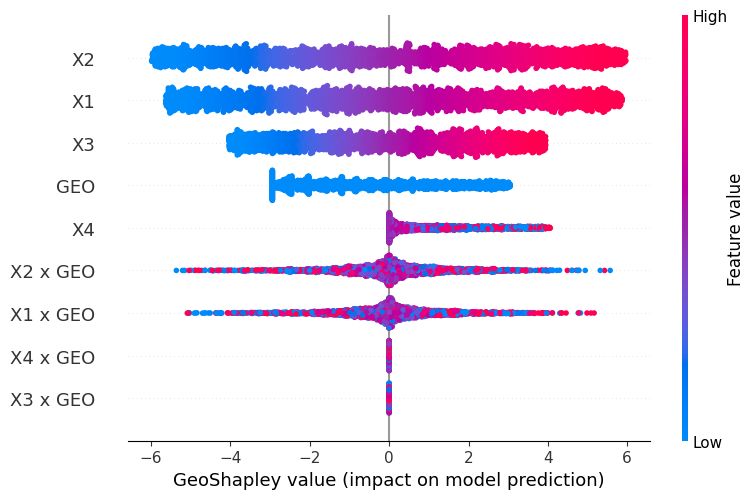

In [15]:
rslt.summary_plot(dpi=100)

## Match GeoShapley with original processes

In [16]:
params = rslt.attribute_to_X(svc_coef_col = [0, 1])

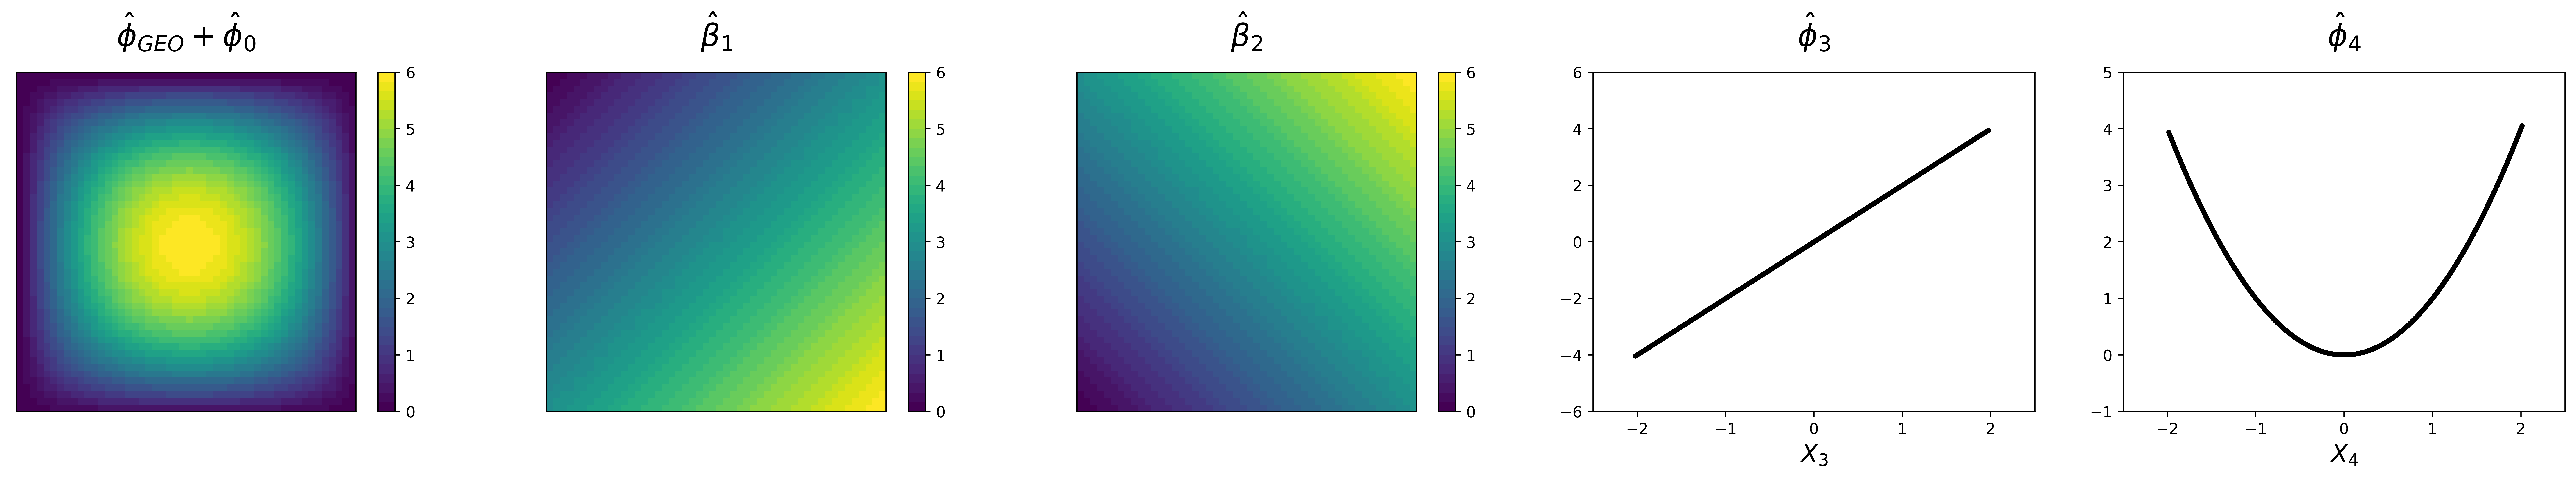

In [17]:
warnings.filterwarnings('ignore')
sub_t = [r"$\hat{\phi}_{GEO}+\hat{\phi}_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\hat{\phi}_{3}$", r"$\hat{\phi}_{4}$"]

plot_s(params.T,vmin=0,vmax=6,sub_title=sub_t,title="True_model",non_spatial=[[3,X_coords.values[:,2],params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],params[:,-1],-1,5]])

## Explanation accuray

In [18]:
np.allclose(params[:,1],b1,atol=1e-3)

True

In [19]:
np.allclose(params[:,2],b2,atol=1e-3)

True

In [20]:
np.allclose(rslt.base_value + rslt.geo,b0,atol=1e-3)

True

In [21]:
np.allclose(params[:,-2],X_coords.values[:,2]*2,atol=1e-3)

True

In [22]:
np.allclose(params[:,-1],X_coords.values[:,3]**2,atol=1e-3)

True